In [134]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Inserisci la tua {var}")


_set_if_undefined("OPENAI_API_KEY")

In [135]:
!pip install openai langchain -q

In [136]:
!wget https://www.bu.edu/geneva/files/2010/08/Easy_recipes.pdf -O "omnivores.pdf"

--2024-05-23 18:01:47--  https://www.bu.edu/geneva/files/2010/08/Easy_recipes.pdf
Resolving www.bu.edu (www.bu.edu)... 108.139.243.42, 108.139.243.124, 108.139.243.61, ...
Connecting to www.bu.edu (www.bu.edu)|108.139.243.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414514 (405K) [application/pdf]
Saving to: ‘omnivores.pdf’

omnivores.pdf       100%[===================>] 404.80K  2.11MB/s    in 0.2s    

2024-05-23 18:01:47 (2.11 MB/s) - ‘omnivores.pdf’ saved [414514/414514]



In [137]:
!wget https://downloads.ctfassets.net/ww1ie0z745y7/1FYv4VlHVZsIuvBBBVPbyh/d12fce76ab4c526f485995e741f274fe/comms-veg-eating-plant-based-cookbook-2021.pdf -O "vegan.pdf"

--2024-05-23 18:01:48--  https://downloads.ctfassets.net/ww1ie0z745y7/1FYv4VlHVZsIuvBBBVPbyh/d12fce76ab4c526f485995e741f274fe/comms-veg-eating-plant-based-cookbook-2021.pdf
Resolving downloads.ctfassets.net (downloads.ctfassets.net)... 3.160.212.27, 3.160.212.99, 3.160.212.122, ...
Connecting to downloads.ctfassets.net (downloads.ctfassets.net)|3.160.212.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14499228 (14M) [application/pdf]
Saving to: ‘vegan.pdf’

vegan.pdf           100%[===================>]  13.83M  7.83MB/s    in 1.8s    

2024-05-23 18:01:50 (7.83 MB/s) - ‘vegan.pdf’ saved [14499228/14499228]



In [138]:
!wget https://completevegetarianbook2015.wordpress.com/wp-content/uploads/2015/02/complete-vegetarian-blad.pdf -O "vegetarian.pdf"

--2024-05-23 18:01:50--  https://completevegetarianbook2015.wordpress.com/wp-content/uploads/2015/02/complete-vegetarian-blad.pdf
Resolving completevegetarianbook2015.wordpress.com (completevegetarianbook2015.wordpress.com)... 192.0.78.13, 192.0.78.12
Connecting to completevegetarianbook2015.wordpress.com (completevegetarianbook2015.wordpress.com)|192.0.78.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13509585 (13M) [application/pdf]
Saving to: ‘vegetarian.pdf’

vegetarian.pdf      100%[===================>]  12.88M  5.28MB/s    in 2.4s    

2024-05-23 18:01:53 (5.28 MB/s) - ‘vegetarian.pdf’ saved [13509585/13509585]



In [306]:
!wget https://www.thefullhelping.com/wp-content/uploads/2013/09/Naturally-Sweet-and-Gluten-Free.pdf -O "vegan.pdf"

--2024-05-24 10:45:04--  https://www.thefullhelping.com/wp-content/uploads/2013/09/Naturally-Sweet-and-Gluten-Free.pdf
Resolving www.thefullhelping.com (www.thefullhelping.com)... 104.26.14.212, 172.67.71.84, 104.26.15.212
Connecting to www.thefullhelping.com (www.thefullhelping.com)|104.26.14.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6408322 (6.1M) [application/pdf]
Saving to: ‘vegan.pdf’

vegan.pdf           100%[===================>]   6.11M  8.99MB/s    in 0.7s    

2024-05-24 10:45:05 (8.99 MB/s) - ‘vegan.pdf’ saved [6408322/6408322]



In [307]:
import shutil
import os
from glob import glob

files = glob("*")

if not os.path.exists('./data'):
    os.mkdir('./data')

for individual_file in files:
    if individual_file.find(".") == -1:
        continue
    file_extension = individual_file.split(".")[-1]
    if not os.path.exists(f"./data/{file_extension}"):
        os.mkdir(f"./data/{file_extension}")
    destination_file = f"./data/{file_extension}/{individual_file}"
    if not os.path.exists(destination_file):
        shutil.move(individual_file, destination_file)
    else:
        print(f"Destination path '{destination_file}' already exists. Skipping.")


Destination path './data/pdf/omnivores.pdf' already exists. Skipping.
Destination path './data/pdf/vegetarian.pdf' already exists. Skipping.
Destination path './data/ipynb/multi-agent-rag.ipynb' already exists. Skipping.


In [141]:
!pip install pypdf

In [308]:
from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader

loader = PyPDFDirectoryLoader("./data/pdf")

docs = loader.load()

Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)


In [309]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 20,
    length_function = len,
)

documents = text_splitter.split_documents(docs)

In [310]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

In [311]:
!pip install chromadb tiktoken -q

In [312]:
from langchain.vectorstores import Chroma

persist_directory = "vector_db"

vectordb = Chroma.from_documents(documents=documents, embedding=embeddings, persist_directory=persist_directory)

In [313]:
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

In [314]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

In [315]:
from langchain.chains import RetrievalQA

general_recipes = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=doc_retriever)

In [316]:
doc_retriever = vectordb.as_retriever()

### Create wolf expert tool with its own retriever

In [317]:
from langchain_community.document_loaders import WebBaseLoader

In [318]:
wolf_general_loader = WebBaseLoader("https://en.wikipedia.org/wiki/Wolf")

In [320]:
wolf_general_docs = wolf_general_loader.load()
wolf_general_texts = text_splitter.split_documents(wolf_general_docs)
wolf_general_db = Chroma.from_documents(wolf_general_texts, embeddings, persist_directory=persist_directory)
wolf_general_db = Chroma(persist_directory=persist_directory, embedding_function=embeddings)
wolf_retriever = wolf_general_db.as_retriever()
wolf_general = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=wolf_retriever)

In [321]:
wolf_general.invoke("What is a wolf?")

{'query': 'What is a wolf?',
 'result': 'A wolf is a large canine native to Eurasia and North America. It is the largest extant member of the family Canidae and is known for its distinctive features such as less pointed ears and muzzle, a shorter torso, and a longer tail. Wolves have fur that is usually mottled white, brown, gray, and black, although arctic subspecies may be nearly all white.'}

### Now let's set a second expert tool with its own retriever

In [ ]:
plant_based_loader = PyPDFLoader("./data/pdf/vegan.pdf")
plant_based_docs = plant_based_loader.load()

In [ ]:
plant_based_db = Chroma.from_documents(plant_based_docs, embeddings, persist_directory=persist_directory)
plant_based_db = Chroma(persist_directory=persist_directory, embedding_function=embeddings)
plant_based_retriever = plant_based_db.as_retriever()
plant_based_recipe = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=plant_based_retriever)

In [ ]:
from langchain.agents import AgentExecutor, create_react_agent, AgentType, Tool, initialize_agent
from langchain_core.prompts import PromptTemplate
from langchain.tools import BaseTool
from langchain.llms import OpenAI

tools = [
    Tool(
        name = "General recipes",
        func=general_recipes.invoke,
        description="useful for when you need to answer questions about general recipes"
    ),
    Tool(
        name="Plant based expert tool",
        func=plant_based_recipe.invoke,
        description="expert tool to use when plant-based recipes are needed"
    ),
    Tool(
        name = "General wolf",
        func=wolf_general.invoke,
        description="useful for when you need to answer general questions about wolves"
    ),
]

In [ ]:
agent = initialize_agent(
    tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

In [291]:
agent.invoke({"input": "Are wolves dangerous?"})



> Entering new AgentExecutor chain...
It would be best to consult the General wolf tool to get accurate information about the danger posed by wolves.
Action: General wolf
Action Input: {}
Observation: {'query': '{}', 'result': "I'm sorry, but it seems like you haven't provided a specific question or context for me to respond to. How can I assist you today?"}
Thought:I need to ask a more specific question about wolves to get a better answer.
Question: Are wolves dangerous to humans?
Thought: I should use the General wolf tool to get information on the danger wolves pose to humans.
Action: General wolf
Action Input: {'query': 'Are wolves dangerous to humans?'}
Observation: {'query': "{'query': 'Are wolves dangerous to humans?'}", 'result': 'Wolves are generally not considered dangerous to humans, as they do not see humans as natural prey. However, their behavior towards humans can be influenced by their prior experiences with people. In some cases, wolves may react aggressively when pr

{'input': 'Are wolves dangerous?',
 'output': 'Wolves are generally not considered dangerous to humans, but their behavior can be influenced by prior experiences with people.'}

In [292]:
template = '''Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}'''

prompt = PromptTemplate.from_template(template)

agent = create_react_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [293]:
agent_executor.invoke({"input": "Are wolves dangerous for humans?"})



> Entering new AgentExecutor chain...
It's important to consider the behavior and characteristics of wolves when determining if they are dangerous to humans.
Action: General wolf
Action Input: {}{'query': '{}', 'result': "I'm sorry, but it seems like you haven't asked a question or provided any context for me to respond to. How can I assist you today?"}I need to ask a more specific question about wolf behavior and interactions with humans.
Action: General wolf
Action Input: {"question": "What is the typical behavior of wolves towards humans?"}{'query': '{"question": "What is the typical behavior of wolves towards humans?"}', 'result': 'The typical behavior of wolves towards humans depends largely on their prior experience with people. Wolves lacking any negative experience of humans or those that are food-conditioned may show little fear of people. Although wolves may react aggressively when provoked, such attacks are mostly limited to quick bites on extremities, and the attacks are 

{'input': 'Are wolves dangerous for humans?',
 'output': 'Wolves are not inherently dangerous to humans, but their behavior towards humans can vary depending on their prior experiences.'}

In [295]:
agent_executor.invoke({"input": "What was the basis for W. Christopher Wozencraft's decision to propose two additional subspecies, familiaris and dingo, under C. lupus in the third edition of Mammal Species of the World published in 2005?"})



> Entering new AgentExecutor chain...
I need to find information about the basis for W. Christopher Wozencraft's decision.
Action: General wolf
Action Input: input: {"question": "basis for proposing subspecies familiaris and dingo under C. lupus"}{'query': 'input: {"question": "basis for proposing subspecies familiaris and dingo under C. lupus"}', 'result': 'The basis for proposing the subspecies familiaris (Linnaeus, 1758) and dingo (Meyer, 1793) under Canis lupus (wolf) was likely due to genetic studies, including a 1999 mitochondrial DNA (mtDNA) study mentioned by mammalogist W. Christopher Wozencraft in the third edition of Mammal Species of the World. These genetic studies likely provided evidence supporting the classification of these subspecies within the Canis lupus species.'}I now know the basis for W. Christopher Wozencraft's decision.
Final Answer: The basis for proposing the subspecies familiaris and dingo under C. lupus was likely due to genetic studies, including a 1999

{'input': "What was the basis for W. Christopher Wozencraft's decision to propose two additional subspecies, familiaris and dingo, under C. lupus in the third edition of Mammal Species of the World published in 2005?",
 'output': 'The basis for proposing the subspecies familiaris and dingo under C. lupus was likely due to genetic studies, including a 1999 mitochondrial DNA study.'}

In [448]:
agent_executor.invoke({"input": "On what basis did W. Christopher Wozencraft propose the inclusion of familiaris and dingo as subspecies under C. lupus in the third edition of Mammal Species of the World published in 2005?"})



> Entering new AgentExecutor chain...
I need to find information about the proposal made by W. Christopher Wozencraft in 2005.
Action: General wolf
Action Input: {"question": "What proposal did W. Christopher Wozencraft make in 2005 regarding familiaris and dingo as subspecies under C. lupus?"}{'query': '{"question": "What proposal did W. Christopher Wozencraft make in 2005 regarding familiaris and dingo as subspecies under C. lupus?"}', 'result': 'In 2005, W. Christopher Wozencraft proposed two additional subspecies under Canis lupus (wolf): familiaris (Linnaeus, 1758) and dingo (Meyer, 1793).'}I now know the final answer
Final Answer: In 2005, W. Christopher Wozencraft proposed familiaris and dingo as subspecies under C. lupus.

> Finished chain.


{'input': 'On what basis did W. Christopher Wozencraft propose the inclusion of familiaris and dingo as subspecies under C. lupus in the third edition of Mammal Species of the World published in 2005?',
 'output': 'In 2005, W. Christopher Wozencraft proposed familiaris and dingo as subspecies under C. lupus.'}

In [322]:
agent_executor.invoke({"input": "What is a vegan substitute for eggs?"})



> Entering new AgentExecutor chain...
I should use the Plant based expert tool to find a vegan substitute for eggs.
Action: Plant based expert tool
Action Input: {"question": "vegan substitute for eggs"}{'query': '{"question": "vegan substitute for eggs"}', 'result': 'For a vegan substitute for eggs in baking, you can use silken tofu. For each large egg you wish to replace, use ¼ cup (60 ml) packed silken tofu. Simply puree the tofu in a food processor or blender before adding it to the batter. Silken tofu works well in recipes where moisture and binding are important.'}I now know the final answer
Final Answer: For a vegan substitute for eggs in baking, you can use silken tofu.

> Finished chain.


{'input': 'What is a vegan substitute for eggs?',
 'output': 'For a vegan substitute for eggs in baking, you can use silken tofu.'}

### Now let's set a second sub-agent inside a tool (Not working)

In [271]:
plant_based_rec_tools = [
    Tool(
        name="Plant based recipes",
        func=plant_based_recipe.invoke,
        description="useful vegan recipes details for people that want plant based diets"
    )
]


In [272]:
sub_agent_template = '''You are a sub-agent specializing in vegan recipes. Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}'''

sub_agent_prompt = PromptTemplate.from_template(sub_agent_template)

In [273]:
plant_based_sub_agent = create_react_agent(
    llm=llm,
    tools=plant_based_rec_tools,
    prompt=sub_agent_prompt
)

plant_based_sub_agent_executor = AgentExecutor(agent=plant_based_sub_agent, tools=plant_based_rec_tools, verbose=True)

In [281]:
main_agent_template = '''Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}'''

main_agent_prompt = PromptTemplate.from_template(main_agent_template)

tools = [
    Tool(
        name="General recipes",
        func=general_recipes.invoke,
        description="useful for when you need to answer questions about general recipes"
    ),
    Tool(
        name="Plant based recipes sub-agent",
        func=plant_based_sub_agent_executor.invoke,
        description="sub-agent useful for detailed vegan recipes"
    ),
    Tool(
        name="General wolf",
        func=wolf_general.invoke,
        description="useful for when you need to answer general questions about wolves"
    ),
]

### Here you should add in the tool list the new sub agents but spoiler it doesn't work (probably deprecated feature)

In [282]:
main_agent = create_react_agent(llm, tools, prompt=main_agent_prompt)
main_agent_executor = AgentExecutor(agent=main_agent, tools=tools, verbose=True)

In [284]:
main_agent_executor.invoke({"input": "I would like a plant based dinner tonight, any suggestion?"})



> Entering new AgentExecutor chain...
I should use the Plant based recipes sub-agent to get a suggestion for a plant-based dinner.
Action: Plant based recipes sub-agent
Action Input: { "request_type": "dinner" }

IndexError: list index out of range

# Agent Supervisor

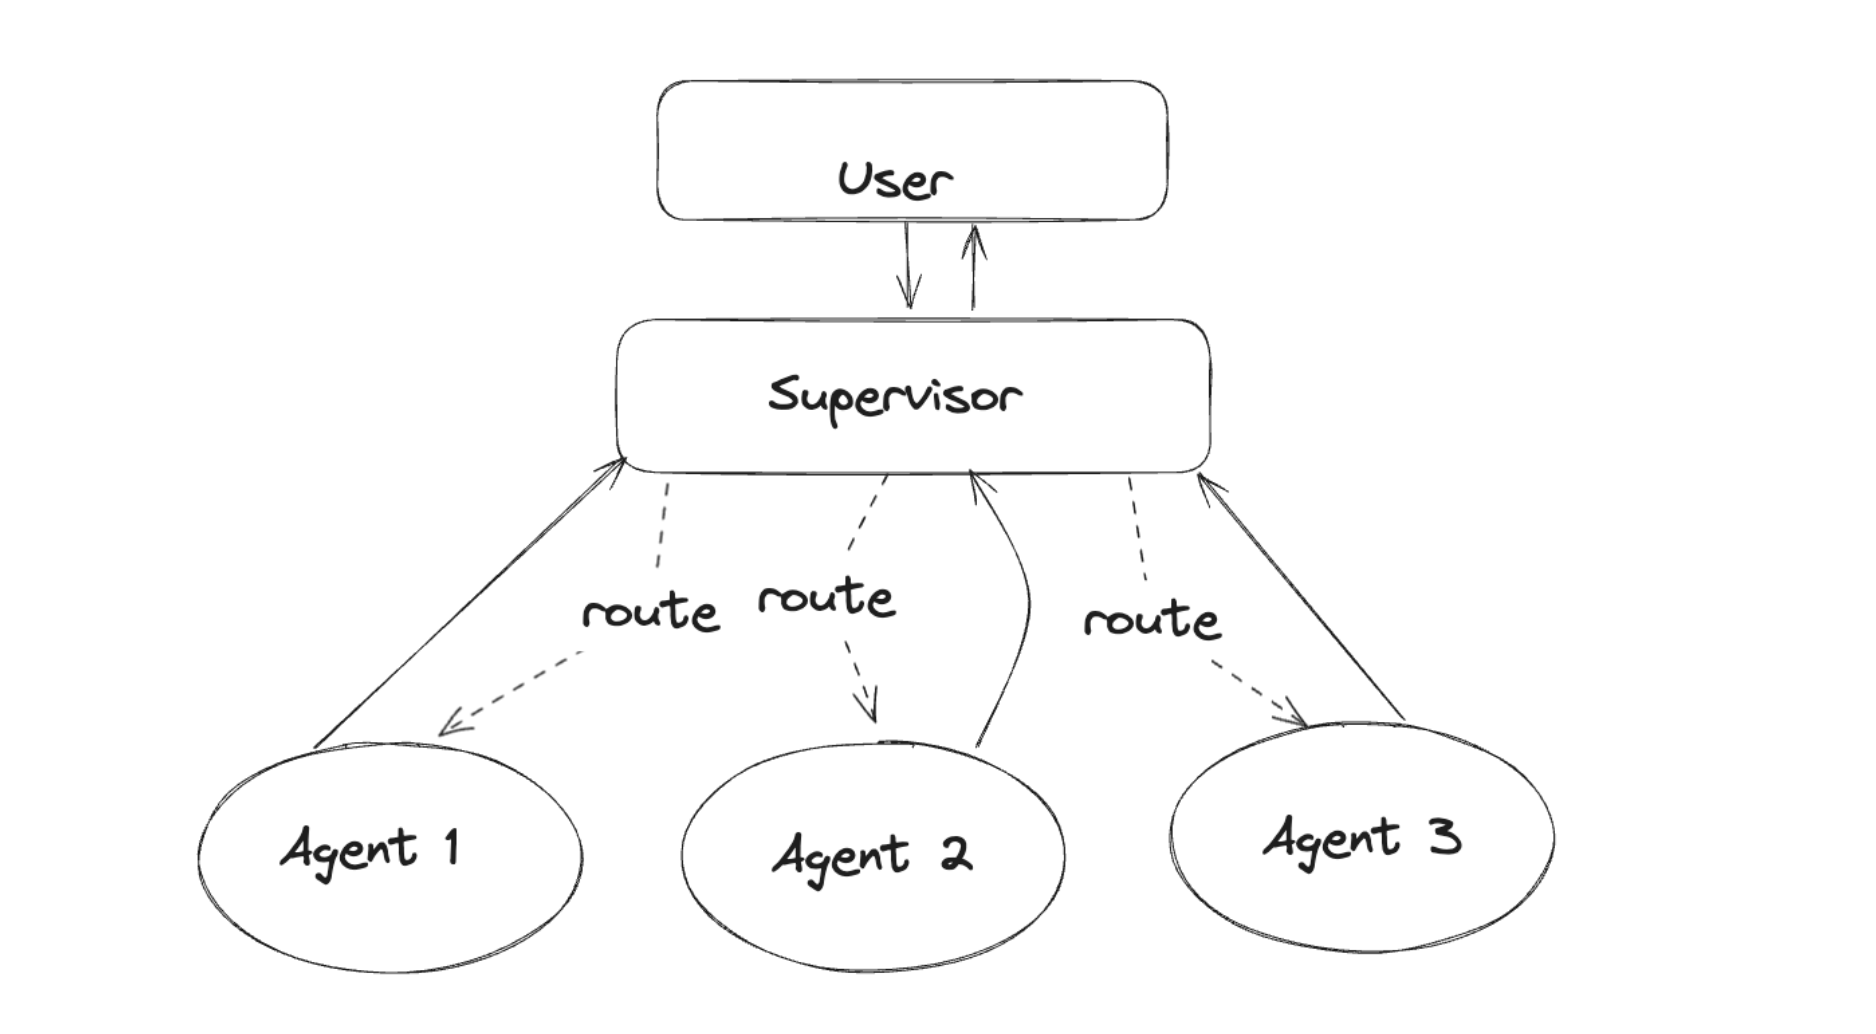

### Helper Utilities
Define a helper function below, which make it easier to add new agent worker nodes.

In [422]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

We can also define a function that we will use to be the nodes in the graph - it takes care of converting the agent response to a human message. This is important because that is how we will add it the global state of the graph

In [423]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Create tools

In [478]:
from langchain.tools.retriever import create_retriever_tool

from langchain_core.tools import tool

food_tool = create_retriever_tool(
    plant_based_retriever,
    name="pant_based_tool",
    description="""Useful tool for plant-based diets""",
)

wolf_tool = create_retriever_tool(
    wolf_retriever,
    name="wolf_tool",
    description="""You can use this to be a wolf expert""",
    
)

### Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

NB: A very interesting thing is the potential to leverage the [function calling features](https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/openai_functions/#jsonkeyoutputfunctionsparser) of OpenAI's model (in theory, this should also be possible with AWS Bedrock models). 

[Vedi qui per approfondire](https://github.com/langchain-ai/langchain/discussions/18541
)

```js
llm.bind_functions
```

In [491]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Nutritionist", "Wolf_expert"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed

options = ["FINISH"] + members

# Using openai function calling can make output parsing easier for us

function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

### Construct Graph
We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [492]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


nutritionist_agent = create_agent(llm, [food_tool], "You are a nutritionist.")
nutritionist_node = functools.partial(agent_node, agent=nutritionist_agent, name="Nutritionist")

wolf_agent = create_agent(
    llm,
    [retrive_tool],
    "You are wolf expert",
)
wolf_node = functools.partial(agent_node, agent=wolf_agent, name="Wolf_expert")

workflow = StateGraph(AgentState)
workflow.add_node("Nutritionist", nutritionist_node)
workflow.add_node("Wolf_expert", wolf_node)
workflow.add_node("supervisor", supervisor_chain)

Now connect all the edges in the graph:

In [486]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

In [488]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Tell me about the evolution of wolves")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Wolf_expert'}}
----
{'Wolf_expert': {'messages': [HumanMessage(content='The evolution of wolves is believed to have occurred from the extinct species Canis etruscus through Canis mosbachensis to the extant wolf species Canis lupus. The earliest fossils of Canis lupus were found in eastern Beringia in Canada and Alaska, dating back to around one million years ago. During the Late Pleistocene, there was considerable morphological diversity among wolves, with features such as robust skulls and teeth, a shortened snout, a pronounced development of the temporalis muscle, and robust premolars. These adaptations were specialized for processing carcasses and bones associated with hunting and scavenging Pleistocene megafauna.\n\nSome Pleistocene wolves exhibited an increase in tooth breakage, similar to the extinct dire wolf, suggesting they either frequently processed carcasses or competed with other carnivores. This evolutionary process led to the development of moder

In [490]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="I have a vegan guest tonight, what dessert may I cook for him?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Nutritionist'}}
----
{'Nutritionist': {'messages': [HumanMessage(content='How about making a vegan cheesecake for your guest tonight? Here is a recipe you can try:\n\n### Vegan Cheesecake Recipe\n- **Ingredients:**\n  - Tofu\n  - Cashew butter\n  - Agave nectar\n  - Lemon zest and juice\n  - Lemon extract\n  - Vanilla extract\n  - Salt\n  - Oil\n  - Almond milk\n  - Arrowroot\n  - All-purpose flour\n  - Sorghum flour\n  - Baking powder\n  - Baking soda\n  - Xanthan gum\n\n- **Instructions:**\n  1. Preheat the oven to 350˚F (180˚C) and prepare an 8-inch square pan.\n  2. Blend tofu and cashew butter in a food processor until smooth.\n  3. Add agave nectar, lemon zest, lemon juice, lemon extract, vanilla, and salt to the mixture and process until velvety.\n  4. In a separate bowl, whisk together oil, agave nectar, milk, and vanilla.\n  5. Sift arrowroot, all-purpose flour, sorghum flour, baking powder, baking soda, xanthan gum, and salt over the wet mixture and s